In [6]:
import torch
import torchvision.models as models
from torch.profiler import profile, ProfilerActivity, record_function

from fedcore.algorithm.low_rank.low_rank_opt import LowRankModel
from fedcore.architecture.utils.misc import count_params
from fedcore.models.network_impl.decomposed_layers import IDecomposed
from fedcore.repository.constanst_repository import SLRStrategiesEnum
import torch.nn as nn
import torch
from fedcore.tools.metrics.two_model_compairing_metrics import compare_accuracy
from fedcore.tools.dataload.small_cifar10_dataloader import get_small_cifar10_train_and_val_loaders
from fedcore.tools.template_fedcore_models import create_low_rank_with_prune_on_0_epoch
import itertools
from copy import deepcopy
import pandas as pd
from fedcore.algorithm.low_rank.hooks import OnetimeRankPruner
from fedcore.tools.ruler import PerformanceEvaluator
import numpy as np
import matplotlib.pyplot as plt

In [7]:
model = models.resnet18()
inputs = torch.randn(5, 3, 224, 224)

In [8]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

In [9]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         6.16%      15.607ms       100.00%     253.529ms     253.529ms             1  
                     aten::conv2d         0.55%       1.392ms        53.24%     134.984ms       6.749ms            20  
                aten::convolution         1.59%       4.026ms        52.69%     133.592ms       6.680ms            20  
               aten::_convolution         0.55%       1.401ms        51.11%     129.566ms       6.478ms            20  
         aten::mkldnn_convolution        49.89%     126.486ms        50.55%     128.165ms       6.408ms            20  
                     aten::linear       

In [11]:
from fedcore.tools.dataload.small_cifar10_dataloader import get_small_cifar10_train_and_val_loaders
from fedcore.tools.template_fedcore_models import create_low_rank_with_prune_on_0_epoch


train_dataloader, val_dataloader = get_small_cifar10_train_and_val_loaders(batch_size=8, val_size=1000)

TRAINED_LR, data = create_low_rank_with_prune_on_0_epoch(train_dataloader, val_dataloader, epochs=0) #TODO почему то уже даже при одной эпохе качество модели падает с 0.93 до 0.6
TRAINED_LR.fit(input_data=data)
print()

Files already downloaded and verified
Files already downloaded and verified
LearningConfig(learning_strategy='from_checkpoint', peft_strategy='low_rank', criterion='cross_entropy', peft_strategy_params=LowRank(log_each=None, eval_each=None, save_each=None, epochs=0, optimizer='adam', scheduler=None, criterion='cross_entropy', custom_learning_params={}, custom_criterions={}, model_architecture=ModelArchitectureConfig(input_dim=None, output_dim=None, depth=3, custom_model_params={}), strategy='quantile', rank_prune_each=-1, compose_mode=None, non_adaptive_threshold=0.5, finetune_params=NeuralModelConfig(log_each=None, eval_each=None, save_each=None, epochs=1, optimizer='adam', scheduler=None, criterion='cross_entropy', custom_learning_params={}, custom_criterions={}, model_architecture=ModelArchitectureConfig(input_dim=None, output_dim=None, depth=3, custom_model_params={}))), learning_strategy_params=NeuralModelConfig(log_each=None, eval_each=None, save_each=None, epochs=1, optimizer='a

In [50]:
def experiment_body(trained_lr: LowRankModel, bs=8, thr=0.05, mode=SLRStrategiesEnum._member_names_[0], comp="one_layer", device_str="cpu", compare_with_decomposed=False, n_eval=8, eval_only_model_before=False, eval_only_model_after=False):
        """COMPAIRING INIT NON DECOMPOSED MODEL (model_before) WITH MODEL_AFTER
        WITH PRUNING
        """
        print(f"Running experiment bs={bs} thr={thr} mode={mode} compose={comp}")
        # copy model for experiment
        trained_lr = deepcopy(trained_lr)
        #model before - is clean Conv2d model
        if (compare_with_decomposed):
            #if we want to compare decomposed (conv Vh and conv S*U) & decomposed+pruned+compose_mode 1, 2, 3
            trained_lr.model_before = deepcopy(trained_lr.model_after)

        #add correct compose_mode before composition by OneTimeRankPruner
        for name, module in trained_lr.model_after.named_modules():
            if isinstance(module, IDecomposed): 
                 module.compose_mode = comp

        #add pruner and execute
        rank_pruner = OnetimeRankPruner()
        rank_pruner.link_to_trainer(trained_lr.trainer)
        rank_pruner.non_adaptive_threshold = thr
        rank_pruner.SLR_strategy = mode
        rank_pruner.action(None, None)
        #after that we have compressed (by threshold) composed view. 1 2 or 3 4D tensors inside

        #creating performance evaluators
        val_loader_after = deepcopy(val_dataloader)
        val_dataloader.num_workers = 8
        val_loader_after.num_workers = 8
        device = torch.device(device_str)
        eval_before = PerformanceEvaluator(trained_lr.model_before, data=val_dataloader, batch_size=bs, device=device, n_batches=n_eval)
        eval_after = PerformanceEvaluator(trained_lr.model_after, data=val_loader_after, batch_size=bs, device=device, n_batches=n_eval)
        
        # run evaluation
        if (eval_only_model_before):
            print("eval model_before")
            eval_before.warm_up_cuda()
            thr = eval_before.throughput_eval(1)
            return trained_lr, {}
        if (eval_only_model_after):
            print("eval model_after")
            eval_after.warm_up_cuda()
            thr = eval_after.throughput_eval(1)
            return trained_lr, {}
        
        print("eval model_before")
        metrics_before = eval_before.eval()
        print("eval model_after")
        metrics_after = eval_after.eval()
        acc_before, acc_after = compare_accuracy(trained_lr.model_before, trained_lr.model_after, val_dataloader)

        # store row
        return trained_lr, {
            "batch_size": bs,
            "threshold": thr,
            "low_rank_mode": mode,
            "compose_mode": comp,
            "device": device_str,
            # before metrics
            "before_latency_mean s": metrics_before.get("latency", [None])[0] if isinstance(metrics_before.get("latency"), (list, tuple)) else None,
            "before_latency_std s": metrics_before.get("latency", [None, None])[1] if isinstance(metrics_before.get("latency"), (list, tuple)) else None,
            "before_throughput_mean s": metrics_before.get("throughput", [None])[0] if isinstance(metrics_before.get("throughput"), (list, tuple)) else None,
            "before_throughput_std s": metrics_before.get("throughput", [None, None])[1] if isinstance(metrics_before.get("throughput"), (list, tuple)) else None,
            "before_model_size_mb": metrics_before.get("model_size", [None])[0] if isinstance(metrics_before.get("model_size"), (list, tuple)) else None,
            "before_params": count_params(trained_lr.model_before),
            "before_accuracy": acc_before,
            # after metrics
            "after_params": count_params(trained_lr.model_after),
            "after_latency_mean s": metrics_after.get("latency", [None])[0] if isinstance(metrics_after.get("latency"), (list, tuple)) else None,
            "after_latency_std s": metrics_after.get("latency", [None, None])[1] if isinstance(metrics_after.get("latency"), (list, tuple)) else None,
            "after_throughput_mean s": metrics_after.get("throughput", [None])[0] if isinstance(metrics_after.get("throughput"), (list, tuple)) else None,
            "after_throughput_std s": metrics_after.get("throughput", [None, None])[1] if isinstance(metrics_after.get("throughput"), (list, tuple)) else None,
            "after_model_size_mb": metrics_after.get("model_size", [None])[0] if isinstance(metrics_after.get("model_size"), (list, tuple)) else None,
            "after_accuracy": acc_after,
        }

def full_experiment(trained_lr: LowRankModel, device_str, compare_with_decomposed=False, n_eval=8):
    batch_sizes = [16] #16, 32]                     # можно расширить до 1..128
    thresholds = [0.1]#[0.0001, 0.1, 0.5, 0.9]#0.1, 0.2, 0.4]
    low_rank_modes = [SLRStrategiesEnum._member_names_[0]]
    compose_modes = ["one_layer"] #["one_layer", "two_layers", "three_layers"]


    rows = []
    all_iterations = len(batch_sizes) * len(thresholds) * len(low_rank_modes) * len(compose_modes)

    # loop over parameter grid
    i = 1
    for bs, thr, mode, comp in itertools.product(batch_sizes, thresholds, low_rank_modes, compose_modes):
        print("STEP:", i, "FROM", all_iterations)
        rows.append(experiment_body(trained_lr, bs, thr, mode, comp, device_str, compare_with_decomposed, n_eval)[1])
        print(f"Done device={device_str} bs={bs} thr={thr} comp={comp}")
        i = i + 1
    return rows

In [13]:
# with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
#     with record_function("model_inference"):
#         experiment_rows = full_experiment(TRAINED_LR, "cpu", n_eval=8)

In [14]:
# print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

In [15]:
# with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
#     with record_function("model_inference"):
#         experiment_body(TRAINED_LR, 
#                         bs=16, 
#                         thr=0.1, 
#                         mode=SLRStrategiesEnum._member_names_[0], 
#                         comp="one_layer", 
#                         device_str="cpu", 
#                         compare_with_decomposed=False, n_eval=8)
# print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
        

### FOR 1 LAYER COMPOSE AFTER THRESHOLDING  
1040 = 20 convd2 layers * 52 call/layer  
52 call/layer = 8 n_eval * 2 (latency + throughput) * 2 (model_b & model_a) + 10 * 2 (compare_accuracy)

###

In [16]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True, with_stack=True) as prof:
    with record_function("model_inference"):
        compressed_model, rows = experiment_body(TRAINED_LR, bs=16, thr=0.1, mode=SLRStrategiesEnum._member_names_[0], comp="two_layers", device_str="cpu", compare_with_decomposed=False, n_eval=8)
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
        

Running experiment bs=16 thr=0.1 mode=quantile compose=two_layers
After rank pruning left only 94 % of conv1 layer params
After rank pruning left only 94 % of layer1.0.conv1 layer params
After rank pruning left only 94 % of layer1.0.conv2 layer params
After rank pruning left only 94 % of layer1.1.conv1 layer params
After rank pruning left only 94 % of layer1.1.conv2 layer params
After rank pruning left only 91 % of layer2.0.conv1 layer params
After rank pruning left only 91 % of layer2.0.conv2 layer params
After rank pruning left only 94 % of layer2.0.downsample.0 layer params
After rank pruning left only 91 % of layer2.1.conv1 layer params
After rank pruning left only 91 % of layer2.1.conv2 layer params
After rank pruning left only 91 % of layer3.0.conv1 layer params
After rank pruning left only 91 % of layer3.0.conv2 layer params
After rank pruning left only 91 % of layer3.0.downsample.0 layer params
After rank pruning left only 91 % of layer3.1.conv1 layer params
After rank pruning 

throughput eval batches: 100%|██████████| 8/8 [00:00<00:00, 25.26batch/s]


eval model_after


throughput eval batches: 100%|██████████| 8/8 [00:00<00:00, 14.63batch/s]


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        20.36%     585.874ms       100.00%        2.877s        2.877s             1  
                                           aten::conv2d         0.48%      13.854ms        38.32%        1.102s     706.669us          1560  
                                      aten::convolution         0.89%      25.661ms        37.85%        1.089s     698.041us          1560  
                                     aten::_convolution         0.99%      28.368ms        36.96%        1.063s     681.565us          1560  
      

1560 = 20 conv layers * 78  
78 = (8 eval * 2 (thr/lat) + 10 accuracy) + (8 eval * 2 thr/lat + 10 accuracy) * 2 (_forward2) = 26 + 52 = 78

In [17]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                        model_inference        20.36%     585.874ms       100.00%        2.877s        2.877s             1                                                                                []  
enumerate(DataLoader)#_SingleProcessDataLoaderIter._...        11.48%     330.295ms        16.88%     48

In [18]:
for name, module in compressed_model.model_after.named_modules():
    if isinstance(module, IDecomposed): 
        print(module.Vh.shape)
        print(module.U.shape)
        print("---")

torch.Size([60, 3, 7, 7])
torch.Size([64, 60, 1, 1])
---
torch.Size([60, 64, 3, 3])
torch.Size([64, 60, 1, 1])
---
torch.Size([60, 64, 3, 3])
torch.Size([64, 60, 1, 1])
---
torch.Size([60, 64, 3, 3])
torch.Size([64, 60, 1, 1])
---
torch.Size([60, 64, 3, 3])
torch.Size([64, 60, 1, 1])
---
torch.Size([116, 64, 3, 3])
torch.Size([128, 116, 1, 1])
---
torch.Size([116, 128, 3, 3])
torch.Size([128, 116, 1, 1])
---
torch.Size([60, 64, 1, 1])
torch.Size([128, 60, 1, 1])
---
torch.Size([116, 128, 3, 3])
torch.Size([128, 116, 1, 1])
---
torch.Size([116, 128, 3, 3])
torch.Size([128, 116, 1, 1])
---
torch.Size([232, 128, 3, 3])
torch.Size([256, 232, 1, 1])
---
torch.Size([232, 256, 3, 3])
torch.Size([256, 232, 1, 1])
---
torch.Size([116, 128, 1, 1])
torch.Size([256, 116, 1, 1])
---
torch.Size([232, 256, 3, 3])
torch.Size([256, 232, 1, 1])
---
torch.Size([232, 256, 3, 3])
torch.Size([256, 232, 1, 1])
---
torch.Size([460, 256, 3, 3])
torch.Size([512, 460, 1, 1])
---
torch.Size([460, 512, 3, 3])
torc

In [19]:
list(TRAINED_LR.model_before.named_modules())[1][1]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [20]:
def compare_module_shapes(lowRankModel):
    new_modules = list(lowRankModel.model_after.named_modules())
    for i, (name, module) in enumerate(lowRankModel.model_before.named_modules()):
        if isinstance(module, torch.nn.Conv2d): 
            print("old", module.weight.shape)
            print("new Vh", new_modules[i][1].Vh.shape)
            print("new U", new_modules[i][1].U.shape)
            print("old", count_params(module), "new", new_modules[i][1].Vh.numel(), "+", new_modules[i][1].U.numel(), "=", count_params(new_modules[i][1]))
            print()
            print("---")

compare_module_shapes(compressed_model)

old torch.Size([64, 3, 7, 7])
new Vh torch.Size([60, 3, 7, 7])
new U torch.Size([64, 60, 1, 1])
old 9408 new 8820 + 3840 = 12660

---
old torch.Size([64, 64, 3, 3])
new Vh torch.Size([60, 64, 3, 3])
new U torch.Size([64, 60, 1, 1])
old 36864 new 34560 + 3840 = 38400

---
old torch.Size([64, 64, 3, 3])
new Vh torch.Size([60, 64, 3, 3])
new U torch.Size([64, 60, 1, 1])
old 36864 new 34560 + 3840 = 38400

---
old torch.Size([64, 64, 3, 3])
new Vh torch.Size([60, 64, 3, 3])
new U torch.Size([64, 60, 1, 1])
old 36864 new 34560 + 3840 = 38400

---
old torch.Size([64, 64, 3, 3])
new Vh torch.Size([60, 64, 3, 3])
new U torch.Size([64, 60, 1, 1])
old 36864 new 34560 + 3840 = 38400

---
old torch.Size([128, 64, 3, 3])
new Vh torch.Size([116, 64, 3, 3])
new U torch.Size([128, 116, 1, 1])
old 73728 new 66816 + 14848 = 81664

---
old torch.Size([128, 128, 3, 3])
new Vh torch.Size([116, 128, 3, 3])
new U torch.Size([128, 116, 1, 1])
old 147456 new 133632 + 14848 = 148480

---
old torch.Size([128, 64

In [21]:
def compare_all_modules_params(lowRankModel):
    new_modules = list(lowRankModel.model_after.named_modules())
    for i, (name, module) in enumerate(lowRankModel.model_before.named_modules()):
        if (len(list(module.children())) == 0):
            print(name)
            print(count_params(module), count_params(new_modules[i][1]))

compare_all_modules_params(compressed_model)

conv1
9408 12660
bn1
128 128
relu
0 0
maxpool
0 0
layer1.0.conv1
36864 38400
layer1.0.bn1
128 128
layer1.0.relu
0 0
layer1.0.conv2
36864 38400
layer1.0.bn2
128 128
layer1.1.conv1
36864 38400
layer1.1.bn1
128 128
layer1.1.relu
0 0
layer1.1.conv2
36864 38400
layer1.1.bn2
128 128
layer2.0.conv1
73728 81664
layer2.0.bn1
256 256
layer2.0.relu
0 0
layer2.0.conv2
147456 148480
layer2.0.bn2
256 256
layer2.0.downsample.0
8192 11520
layer2.0.downsample.1
256 256
layer2.1.conv1
147456 148480
layer2.1.bn1
256 256
layer2.1.relu
0 0
layer2.1.conv2
147456 148480
layer2.1.bn2
256 256
layer3.0.conv1
294912 326656
layer3.0.bn1
512 512
layer3.0.relu
0 0
layer3.0.conv2
589824 593920
layer3.0.bn2
512 512
layer3.0.downsample.0
32768 44544
layer3.0.downsample.1
512 512
layer3.1.conv1
589824 593920
layer3.1.bn1
512 512
layer3.1.relu
0 0
layer3.1.conv2
589824 593920
layer3.1.bn2
512 512
layer4.0.conv1
1179648 1295360
layer4.0.bn1
1024 1024
layer4.0.relu
0 0
layer4.0.conv2
2359296 2355200
layer4.0.bn2
1024 1024

In [22]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                        model_inference        20.36%     585.874ms       100.00%        2.877s        2.877s             1                                                                                []  
enumerate(DataLoader)#_SingleProcessDataLoaderIter._...        11.48%     330.295ms        16.88%     48

In [23]:
print(torch.cuda.is_available())

True


In [51]:
#with_flops=True
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
             #with_stack=True, 
             record_shapes=True,
             #experimental_config=torch._C._profiler._ExperimentalConfig(verbose=True),
             ) as prof:
    with record_function("model_inference"):
        ret_model, rows = experiment_body(TRAINED_LR, 
                                          bs=16, 
                                          thr=0.2, 
                                          mode=SLRStrategiesEnum._member_names_[0], 
                                          comp="three_layers", 
                                          device_str="cuda", 
                                          compare_with_decomposed=False, n_eval=8,
                                          eval_only_model_after=True)


Running experiment bs=16 thr=0.2 mode=quantile compose=three_layers
After rank pruning left only 81 % of conv1 layer params
After rank pruning left only 81 % of layer1.0.conv1 layer params
After rank pruning left only 81 % of layer1.0.conv2 layer params
After rank pruning left only 81 % of layer1.1.conv1 layer params
After rank pruning left only 81 % of layer1.1.conv2 layer params
After rank pruning left only 81 % of layer2.0.conv1 layer params
After rank pruning left only 81 % of layer2.0.conv2 layer params
After rank pruning left only 81 % of layer2.0.downsample.0 layer params
After rank pruning left only 81 % of layer2.1.conv1 layer params
After rank pruning left only 81 % of layer2.1.conv2 layer params
After rank pruning left only 80 % of layer3.0.conv1 layer params
After rank pruning left only 80 % of layer3.0.conv2 layer params
After rank pruning left only 81 % of layer3.0.downsample.0 layer params
After rank pruning left only 80 % of layer3.1.conv1 layer params
After rank prunin

throughput eval batches: 100%|██████████| 8/8 [00:00<00:00, 16.73batch/s]


In [ ]:
print(count_params(ret_model.model_before))
print(count_params(ret_model.model_after))

11181642
10179510


In [ ]:
compare_module_shapes(ret_model)

old torch.Size([64, 3, 7, 7])
new Vh torch.Size([52, 3, 7, 7])
new U torch.Size([64, 52, 1, 1])
old 9408 new 7644 + 3328 = 10972

---
old torch.Size([64, 64, 3, 3])
new Vh torch.Size([52, 64, 3, 3])
new U torch.Size([64, 52, 1, 1])
old 36864 new 29952 + 3328 = 33280

---
old torch.Size([64, 64, 3, 3])
new Vh torch.Size([52, 64, 3, 3])
new U torch.Size([64, 52, 1, 1])
old 36864 new 29952 + 3328 = 33280

---
old torch.Size([64, 64, 3, 3])
new Vh torch.Size([52, 64, 3, 3])
new U torch.Size([64, 52, 1, 1])
old 36864 new 29952 + 3328 = 33280

---
old torch.Size([64, 64, 3, 3])
new Vh torch.Size([52, 64, 3, 3])
new U torch.Size([64, 52, 1, 1])
old 36864 new 29952 + 3328 = 33280

---
old torch.Size([128, 64, 3, 3])
new Vh torch.Size([104, 64, 3, 3])
new U torch.Size([128, 104, 1, 1])
old 73728 new 59904 + 13312 = 73216

---
old torch.Size([128, 128, 3, 3])
new Vh torch.Size([104, 128, 3, 3])
new U torch.Size([128, 104, 1, 1])
old 147456 new 119808 + 13312 = 133120

---
old torch.Size([128, 64

In [53]:

#prof.export_stacks("two_layers_stacktrace") # !!! WARN doesnt supporting anymore
prof.export_chrome_trace("three_layer_profile_thr_02_bs_16_8_workers_load.json")

In [52]:
print(prof.key_averages().table(sort_by="cpu_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        25.27%     286.579ms       100.00%        1.134s        1.134s     200.750ms        17.71%        1.133s        1.133s             1  
enumerate(DataLoader)#_SingleProcessDataLoaderIter._...        18.89%     214.210ms        41.92%     475.317ms      31.688ms     146.286ms        12.91%     395.695ms      26.380ms            15  
         

In [ ]:
prof.events()[1] #буквально ивенты и их дети
#id = 691715

{(<ProfilerAction.NONE: 0>, <ProfilerAction.NONE: 0>): [],
 (<ProfilerAction.NONE: 0>,
  <ProfilerAction.WARMUP: 1>): [<bound method _KinetoProfile.prepare_trace of <torch.profiler.profiler.profile object at 0x000002D93101DF60>>],
 (<ProfilerAction.NONE: 0>,
  <ProfilerAction.RECORD: 2>): [<bound method _KinetoProfile.prepare_trace of <torch.profiler.profiler.profile object at 0x000002D93101DF60>>, <bound method _KinetoProfile.start_trace of <torch.profiler.profiler.profile object at 0x000002D93101DF60>>],
 (<ProfilerAction.NONE: 0>,
  <ProfilerAction.RECORD_AND_SAVE: 3>): [<bound method _KinetoProfile.prepare_trace of <torch.profiler.profiler.profile object at 0x000002D93101DF60>>, <bound method _KinetoProfile.start_trace of <torch.profiler.profiler.profile object at 0x000002D93101DF60>>],
 (<ProfilerAction.WARMUP: 1>,
  <ProfilerAction.NONE: 0>): [functools.partial(<built-in function warn>, 'Incorrect schedule: WARMUP followed by NONE'), <bound method _KinetoProfile.start_trace of <t

In [27]:
#with_flops=True
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
             with_stack=True, 
             record_shapes=True,
             #experimental_config=torch._C._profiler._ExperimentalConfig(verbose=True),
             ) as prof_after:
    with record_function("model_inference"):
        ret_model_3, _ = experiment_body(TRAINED_LR, 
                                          bs=16, 
                                          thr=0.2,
                                          mode=SLRStrategiesEnum._member_names_[0], 
                                          comp="two_layers", 
                                          device_str="cuda", 
                                          compare_with_decomposed=False, 
                                          n_eval=8,
                                          eval_only_model_after=True)
        
#with_flops=True
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
             with_stack=True, 
             record_shapes=True,
             #experimental_config=torch._C._profiler._ExperimentalConfig(verbose=True),
             ) as prof_before:
    with record_function("model_inference"):
        ret_model_3, _ = experiment_body(TRAINED_LR, 
                                          bs=16, 
                                          thr=0.2,
                                          mode=SLRStrategiesEnum._member_names_[0], 
                                          comp="two_layers", 
                                          device_str="cuda", 
                                          compare_with_decomposed=False, 
                                          n_eval=8,
                                          eval_only_model_before=True)


Running experiment bs=16 thr=0.2 mode=quantile compose=two_layers
After rank pruning left only 81 % of conv1 layer params
After rank pruning left only 81 % of layer1.0.conv1 layer params
After rank pruning left only 81 % of layer1.0.conv2 layer params
After rank pruning left only 81 % of layer1.1.conv1 layer params
After rank pruning left only 81 % of layer1.1.conv2 layer params
After rank pruning left only 81 % of layer2.0.conv1 layer params
After rank pruning left only 81 % of layer2.0.conv2 layer params
After rank pruning left only 81 % of layer2.0.downsample.0 layer params
After rank pruning left only 81 % of layer2.1.conv1 layer params
After rank pruning left only 81 % of layer2.1.conv2 layer params
After rank pruning left only 80 % of layer3.0.conv1 layer params
After rank pruning left only 80 % of layer3.0.conv2 layer params
After rank pruning left only 81 % of layer3.0.downsample.0 layer params
After rank pruning left only 80 % of layer3.1.conv1 layer params
After rank pruning 

throughput eval batches: 100%|██████████| 8/8 [00:00<00:00, 12.14batch/s]


Running experiment bs=16 thr=0.2 mode=quantile compose=two_layers
After rank pruning left only 81 % of conv1 layer params
After rank pruning left only 81 % of layer1.0.conv1 layer params
After rank pruning left only 81 % of layer1.0.conv2 layer params
After rank pruning left only 81 % of layer1.1.conv1 layer params
After rank pruning left only 81 % of layer1.1.conv2 layer params
After rank pruning left only 81 % of layer2.0.conv1 layer params
After rank pruning left only 81 % of layer2.0.conv2 layer params
After rank pruning left only 81 % of layer2.0.downsample.0 layer params
After rank pruning left only 81 % of layer2.1.conv1 layer params
After rank pruning left only 81 % of layer2.1.conv2 layer params
After rank pruning left only 80 % of layer3.0.conv1 layer params
After rank pruning left only 80 % of layer3.0.conv2 layer params
After rank pruning left only 81 % of layer3.0.downsample.0 layer params
After rank pruning left only 80 % of layer3.1.conv1 layer params
After rank pruning 

throughput eval batches: 100%|██████████| 8/8 [00:00<00:00, 12.34batch/s]


In [28]:
print(prof_after.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls                                                                      Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                        model_inference        25.86%     395.567ms       100.00%        1.529s        1.529s     288.908ms        18.90%      

In [29]:
print(prof_before.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls                                                                      Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                        model_inference        33.93%     491.300ms       100.00%        1.448s        1.448s     306.908ms        21.21%      

#time total = avg * n

In [30]:
conv2d_info_after = []
for element in prof_after.key_averages(group_by_input_shape=True):
    if (element.key == "aten::conv2d"):
        print(element.key, element.cpu_time, element.input_shapes)
        conv2d_info_after.append((element.key, element.cpu_time, np.cumprod(element.input_shapes[1])[-1]))
#кажется идут по порядку, значит можем сравнить каждую пару с одним модулем из before

aten::conv2d 299.09090909090907 [[16, 3, 32, 32], [52, 3, 7, 7], [], [], [], [], []]
aten::conv2d 541.1818181818181 [[16, 52, 16, 16], [64, 52, 1, 1], [], [], [], [], []]
aten::conv2d 589.4772727272727 [[16, 64, 8, 8], [52, 64, 3, 3], [], [], [], [], []]
aten::conv2d 175.5681818181818 [[16, 52, 8, 8], [64, 52, 1, 1], [], [], [], [], []]
aten::conv2d 453.54545454545456 [[16, 64, 8, 8], [104, 64, 3, 3], [], [], [], [], []]
aten::conv2d 179.79545454545453 [[16, 104, 4, 4], [128, 104, 1, 1], [], [], [], [], []]
aten::conv2d 641.7272727272727 [[16, 128, 4, 4], [104, 128, 3, 3], [], [], [], [], []]
aten::conv2d 195.0909090909091 [[16, 64, 8, 8], [52, 64, 1, 1], [], [], [], [], []]
aten::conv2d 196.0 [[16, 52, 4, 4], [128, 52, 1, 1], [], [], [], [], []]
aten::conv2d 541.8181818181819 [[16, 128, 4, 4], [204, 128, 3, 3], [], [], [], [], []]
aten::conv2d 227.79545454545453 [[16, 204, 2, 2], [256, 204, 1, 1], [], [], [], [], []]
aten::conv2d 538.4242424242424 [[16, 256, 2, 2], [204, 256, 3, 3], [

In [ ]:
len(conv2d_info_after)

19

#пример с input [16, 256, 2, 2] и conv_w = [204, 256, 1, 1]

256 фичей по 2x2   
умножаются на свёртки которые съедают 256 фичей и 1x1 каждая, при этом их 204  
применений свёртки (H - h) * (W - w), где HW исход изобр, hw - размер свёртки (если не учит pad и strat)  
при применении свёртки происходит h * w операций
и такая свёртка применяется в глубину на in_shape
Итого: in_shape * (h * w) * (~H * W) операций на 1 3д свёртку  
А их ещё out_shape, поэтому всего in_shape * out_shape * (h * w) * (~H * W)  
а думал что просто in_shape * h * w * out_shape  
Т. е. свёртка ещё и зависит от удобства внутреннего разбиения. От удобства того, какой
после первого полуслоя придёт тензор. Хотя на самом деле член (H * W) можно и не учитывать, как я вижу он остаётся неизменным, меняются in и out.

In [31]:
conv2d_info_before = []
for element in prof_before.key_averages(group_by_input_shape=True):
    if (element.key == "aten::conv2d"):
        print(element.key, element.cpu_time, element.input_shapes)
        conv2d_info_before.append((element.key, element.cpu_time, np.cumprod(element.input_shapes[1])[-1]))

aten::conv2d 306.09090909090907 [[16, 3, 32, 32], [64, 3, 7, 7], [], [], [], [], []]
aten::conv2d 263.6818181818182 [[16, 64, 8, 8], [64, 64, 3, 3], [], [], [], [], []]
aten::conv2d 359.09090909090907 [[16, 64, 8, 8], [128, 64, 3, 3], [], [], [], [], []]
aten::conv2d 235.78787878787878 [[16, 128, 4, 4], [128, 128, 3, 3], [], [], [], [], []]
aten::conv2d 104.72727272727273 [[16, 64, 8, 8], [128, 64, 1, 1], [], [], [], [], []]
aten::conv2d 202.36363636363637 [[16, 128, 4, 4], [256, 128, 3, 3], [], [], [], [], []]
aten::conv2d 211.66666666666666 [[16, 256, 2, 2], [256, 256, 3, 3], [], [], [], [], []]
aten::conv2d 156.0909090909091 [[16, 128, 4, 4], [256, 128, 1, 1], [], [], [], [], []]
aten::conv2d 139.54545454545453 [[16, 256, 2, 2], [512, 256, 3, 3], [], [], [], [], []]
aten::conv2d 139.03030303030303 [[16, 512, 1, 1], [512, 512, 3, 3], [], [], [], [], []]
aten::conv2d 275.72727272727275 [[16, 256, 2, 2], [512, 256, 1, 1], [], [], [], [], []]


In [ ]:
print("64x3x7x7", (173 + 218) / 193)
print("64x64x3x3", (368 + 114) / 150)
print("512x512x3x3", (337 + 115) / 154)
print("512x256x1x1", (186 + 106) / 217)
print("128x128x3x3", (440 + 109) / 150)
print("128x64x3x3", (228 + 109) / 226)

64x3x7x7 2.0259067357512954
64x64x3x3 3.2133333333333334
512x512x3x3 2.935064935064935
512x256x1x1 1.3456221198156681
128x128x3x3 3.66
128x64x3x3 1.491150442477876


In [ ]:
np.array(conv2d_info_before).shape
#22 так как 11 сгруппированных на 2 (latency и throughput)

(11, 3)

In [ ]:
print("512x256x1x1 conv", (151 + 188) / 263) #логично что первый член меньше, так как 204x256 меньше 512x204
print("old 131072 new 52224 + 104448 = 156672")

print("512x512x3x3 conv", (578 + 232) / 778) #412x512x3x3 and 512x412x1x1 - в сумме членов меньше, но сумма параметров больше
print("old 2359296 new 1898496 + 210944 = 2109440")

print("64x3 (first) conv", (541 + 332) / 506)
print("old 9408 new 7644 + 3328 = 10972")

print("64x64 (second) conv", (364 + 146) / 392) #52x64x3x3 and 64x52x1x1
print("old 36864 new 29952 + 3328 = 33280")

512x256x1x1 conv 1.2889733840304183
old 131072 new 52224 + 104448 = 156672
512x512x3x3 conv 1.0411311053984575
old 2359296 new 1898496 + 210944 = 2109440
64x3 (first) conv 1.725296442687747
old 9408 new 7644 + 3328 = 10972
64x64 (second) conv 1.3010204081632653
old 36864 new 29952 + 3328 = 33280


В общем на процессоре я бы поставил под вопрос, из за того ли, что у нас какие-то overheadы есть, или из-за того, что просто становится два умножения.
Из оверхедов я вижу только gap между свёртками, но обычно он не превышает 50ns. Однако это лишь
примерно от 1/5 до 1/16.

Если на gpu обнаружится ещё больший gap на расходы - ответ будет однозначным за переписывание. Если нет - то тут скорее дело кроется в природе разложенных матриц.

Проверить на 0.5 - там не давало результатов тоже.

В целом видно, что действительно время увеличивается больше для маленьких свёрток, так как время на её разложении падает не сильно (по сравнению с добавкой от второго слагаемого).

Плюс не забываем про gap постоянный примерно в 50ns

In [ ]:
compare_module_shapes(ret_model_3)

old torch.Size([64, 3, 7, 7])
new Vh torch.Size([52, 3, 7, 7])
new U torch.Size([64, 52, 1, 1])
old 9408 new 7644 + 3328 = 10972

---
old torch.Size([64, 64, 3, 3])
new Vh torch.Size([52, 64, 3, 3])
new U torch.Size([64, 52, 1, 1])
old 36864 new 29952 + 3328 = 33280

---
old torch.Size([64, 64, 3, 3])
new Vh torch.Size([52, 64, 3, 3])
new U torch.Size([64, 52, 1, 1])
old 36864 new 29952 + 3328 = 33280

---
old torch.Size([64, 64, 3, 3])
new Vh torch.Size([52, 64, 3, 3])
new U torch.Size([64, 52, 1, 1])
old 36864 new 29952 + 3328 = 33280

---
old torch.Size([64, 64, 3, 3])
new Vh torch.Size([52, 64, 3, 3])
new U torch.Size([64, 52, 1, 1])
old 36864 new 29952 + 3328 = 33280

---
old torch.Size([128, 64, 3, 3])
new Vh torch.Size([104, 64, 3, 3])
new U torch.Size([128, 104, 1, 1])
old 73728 new 59904 + 13312 = 73216

---
old torch.Size([128, 128, 3, 3])
new Vh torch.Size([104, 128, 3, 3])
new U torch.Size([128, 104, 1, 1])
old 147456 new 119808 + 13312 = 133120

---
old torch.Size([128, 64

In [ ]:
i = 0
for name, child in ret_model_3.model_before.named_modules():
    if (isinstance(child, nn.Conv2d)):
        print(child, i)
        i += 1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 0
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) 1
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) 2
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) 3
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) 4
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False) 5
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) 6
Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False) 7
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) 8
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) 9
Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False) 10
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) 11
Conv2d(128, 256, kernel_size=(1, 1), stride

In [ ]:
#df_compare_conv2d = pd.DataFrame()
# df_compare_conv2d["before_time"] = np.array(conv2d_info_before)[:, 1]
# df_compare_conv2d["before_params"] = np.array(conv2d_info_before)[:, 2]



# merged_conv2d_after = []
# for i in range(0, len(conv2d_info_after) - 1, 2): #почему то не хватило пары
#     sum_time = conv2d_info_after[i][1] + conv2d_info_after[i+1][1]
#     sum_params = conv2d_info_after[i][2] + conv2d_info_after[i+1][2]
#     merged_conv2d_after.append((sum_time, sum_params))

# df_compare_conv2d["after_time"] = np.array(merged_conv2d_after)[:, 0]
# df_compare_conv2d["after_params"] = np.array(merged_conv2d_after)[:, 1]

In [32]:
df_operations = pd.DataFrame()
df_operations["times"] = np.array(conv2d_info_after + conv2d_info_before)[:, 1]
df_operations["params"] = np.array(conv2d_info_after + conv2d_info_before)[:, 2]
df_operations["params"] = pd.to_numeric(df_operations["params"], errors="coerce")
df_operations["times"] = pd.to_numeric(df_operations["times"], errors="coerce")
df_operations = df_operations.sort_values(by=["params"],)


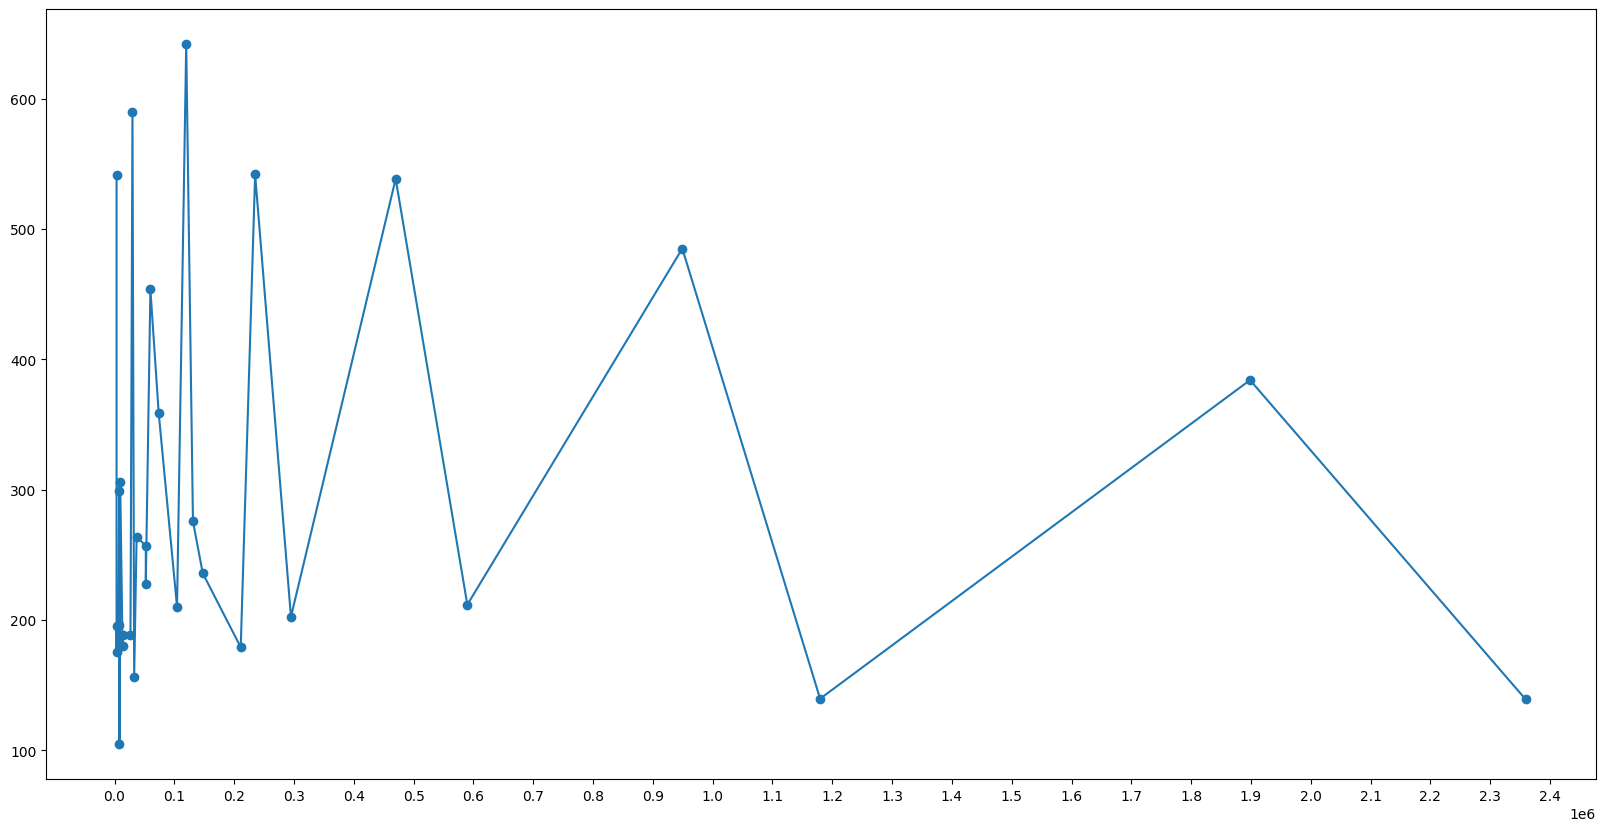

In [39]:
plt.figure(figsize=(20, 10))
plt.xticks(np.arange(1, 3000000, 100000))
plt.plot(df_operations["params"], df_operations["times"])
plt.scatter(df_operations["params"], df_operations["times"])

# plt.figure(figsize=(20, 10))
# plt.xticks(np.arange(1, 3000000, 100000))
# plt.xscale('log')
# plt.plot(df_operations["params"], df_operations["times"])
# plt.scatter(df_operations["params"], df_operations["times"])

299.0015514595425

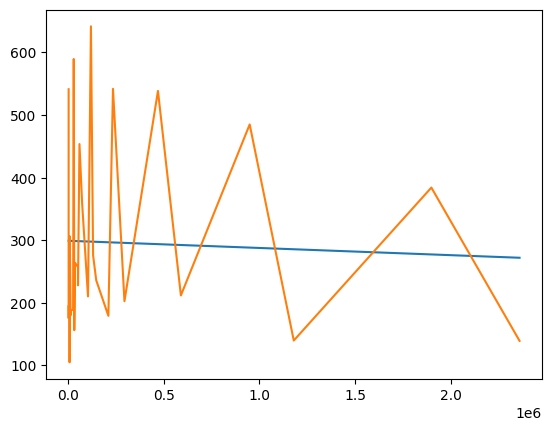

In [40]:
from scipy.optimize import curve_fit
infodict = curve_fit(lambda x, a, b: a * x + b, df_operations["params"], df_operations["times"])
plt.plot(df_operations["params"], infodict[0][0] * df_operations["params"] + infodict[0][1])
plt.plot(df_operations["params"], df_operations["times"])
infodict[0][1]

In [ ]:
def compare_module_shapes_2(lowRankModel):
    new_modules = list(lowRankModel.model_after.named_modules())
    for i, (name, module) in enumerate(lowRankModel.model_before.named_modules()):
        if isinstance(module, torch.nn.Conv2d): 
            # print("old", module.weight.shape)
            # print("new Vh", new_modules[i][1].Vh.shape)
            # print("new U", new_modules[i][1].U.shape)
            print("old", count_params(module), "new", new_modules[i][1].Vh.numel(), "+", new_modules[i][1].U.numel(), "=", count_params(new_modules[i][1]))

compare_module_shapes_2(ret_model_3)

old 9408 new 7644 + 3328 = 10972
old 36864 new 29952 + 3328 = 33280
old 36864 new 29952 + 3328 = 33280
old 36864 new 29952 + 3328 = 33280
old 36864 new 29952 + 3328 = 33280
old 73728 new 59904 + 13312 = 73216
old 147456 new 119808 + 13312 = 133120
old 8192 new 3328 + 6656 = 9984
old 147456 new 119808 + 13312 = 133120
old 147456 new 119808 + 13312 = 133120
old 294912 new 235008 + 52224 = 287232
old 589824 new 470016 + 52224 = 522240
old 32768 new 13312 + 26624 = 39936
old 589824 new 470016 + 52224 = 522240
old 589824 new 470016 + 52224 = 522240
old 1179648 new 949248 + 210944 = 1160192
old 2359296 new 1898496 + 210944 = 2109440
old 131072 new 52224 + 104448 = 156672
old 2359296 new 1898496 + 210944 = 2109440
old 2359296 new 1898496 + 210944 = 2109440


In [ ]:
print(count_params(ret_model_3.model_before))
print(count_params(ret_model_3.model_after))

11181642
10179510


In [ ]:
prof_after.export_chrome_trace("prof_after_two_layer_thr_02_cuda2.json")